In [246]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

# 고객 행동 예측

### 1 : 데이터 읽고 확인

In [247]:
import pandas as pd

uselog = pd.read_csv('./data/use_log.csv')
customer_join = pd.read_csv('./data/customer_join.csv')

In [248]:
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [249]:
customer_join.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [250]:
customer_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        4192 non-null   object 
 1   name               4192 non-null   object 
 2   class              4192 non-null   object 
 3   gender             4192 non-null   object 
 4   start_date         4192 non-null   object 
 5   end_date           1350 non-null   object 
 6   campaign_id        4192 non-null   object 
 7   is_deleted         4192 non-null   int64  
 8   class_name         4192 non-null   object 
 9   price              4192 non-null   int64  
 10  campaign_name      4192 non-null   object 
 11  mean               4192 non-null   float64
 12  median             4192 non-null   float64
 13  max                4192 non-null   int64  
 14  min                4192 non-null   int64  
 15  routine_flg        4192 non-null   int64  
 16  calc_date          4192 

### 2 : 클러스터링으로 회원 그룹화(K-means 알고리즘)
* 2-1. 클러스터링을 위한 feature 선정 : mean, median, max, min, membership_period
* 2-2. feature 추출, 클러스터 개수 지정 (4개)
    * 각 feature 특성을 파악해서 표준화 필요한 부분 체크 
    * mean/median/max/min은 최댓값이 1-8, membership period는 47로 편차가 크기 때문에 표준화 필요 (Standard Scaler)

In [251]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

* 표준화 작업

In [252]:
# 스케일 처리할 칼럼만 뽑기
customer_clustering = customer_join[['mean','median','max','min','membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [253]:
customer_clustering.describe()

,mean,median,max,min,membership_period
count,4192.000000,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269,18.835878
std,1.777533,1.874874,2.168959,1.951565,13.848148
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000,7.000000
50%,5.000000,5.000000,8.000000,3.000000,15.000000
75%,6.416667,6.500000,9.000000,4.000000,30.000000
max,12.000000,12.000000,14.000000,12.000000,47.000000


In [254]:

scaler = StandardScaler()
customer_clustering_sc = scaler.fit_transform(customer_clustering)
customer_clustering_sc

array([[-0.28120614, -0.13367635,  0.08117747, -0.5336197 ,  2.03402524],
       [-0.14054502, -0.13367635, -0.37992814, -0.02114919,  2.03402524],
       [-0.42186727, -0.13367635, -0.84103375, -0.02114919,  2.03402524],
       ...,
       [ 1.50050144,  1.46662237,  0.08117747,  2.54120338, -1.28811491],
       [ 3.18843493,  3.06692109,  1.46449428,  4.07861492, -1.28811491],
       [ 2.62579043,  2.53348819,  1.00338868,  3.56614441, -1.28811491]])

In [255]:
# customer_clustering_sc.describe()

In [256]:
#kmeans 군집화 머신러닝
kmeans = KMeans(n_clusters=4, random_state=0)       # 머신러닝 알고리즘 선언
clusters = kmeans.fit(customer_clustering_sc)       # 머신러닝 학습


customer_clustering['cluster'] = clusters.labels_   # k-means의 경우 비지도 학습으로 X값만 입력하지만 모델 학습 결과 y값(label)이 리턴된다. 이를 받아서 넣어줘야됨
print(customer_clustering['cluster'].unique())
customer_clustering

[3 2 0 1]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3
...,...,...,...,...,...,...
4187,8.000000,8.0,8,8,1,1
4188,10.000000,10.0,10,10,1,1
4189,8.000000,8.0,8,8,1,1
4190,11.000000,11.0,11,11,1,1


### 3 : 클러스터링 결과 분석

In [257]:
# 칼럼 이름 보기 쉽게 리네임
customer_clustering.columns = ['월평균값','월중앙값','월최댓값','월최솟값','회원기간','cluster']
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,846,846,846,846,846
2,763,763,763,763,763
3,1249,1249,1249,1249,1249


In [258]:
customer_clustering.groupby('cluster').mean()

# -> 그룹 0: 회원기간이 길고 적당히 나오는 편
# -> 그룹 1: 회원기간은 7로 가장 짧지만 월평균 이용은 8로 가장 높다
# -> 그룹 2: 회원기간이 중간인데 월이용률이 가장 적다
# -> 그룹 3: 회원기간이 가장 길지만 월 평균값은 전체 그룹 평균이랑 비슷
# --> 그룹별로 다른 마케팅 전략 시도 가능

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,3.054713,2.888598,4.756225,1.653997,9.263434
3,4.677494,4.671337,7.232986,2.153723,36.915933


### 4 : 클러스터링 결과 가시화

In [259]:
from sklearn.decomposition import PCA

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

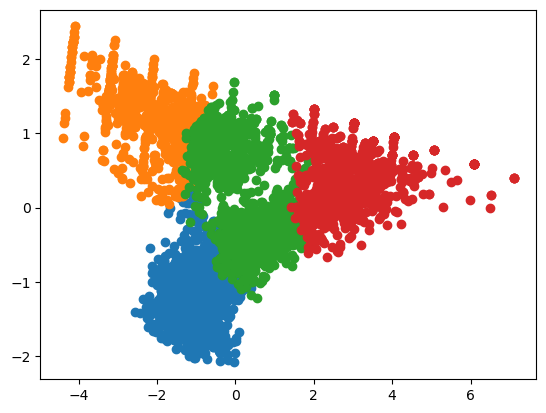

In [260]:
import matplotlib.pyplot as plt

for i in customer_clustering['cluster'].unique():
    tmp = pca_df.loc[pca_df['cluster']==i]
    plt.scatter(tmp[0],tmp[1])

### 5 : 클러스터링 결과를 바탕으로 탈퇴회원 경향 파악

In [261]:
# 4개의 그룹에서 지속 회원과 탈퇴 회원이 얼마나 있을까?
# 지속회원과 탈퇴 회원을 집계: is_deleted열

In [262]:
final_df = customer_join.copy()
final_df['cluster'] = customer_clustering['cluster']

In [263]:
final_df.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,cluster
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47,3
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47,3
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47,3
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47,3
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47,3


In [264]:
final_df.groupby(['cluster','is_deleted'],as_index=False).count()[['cluster','is_deleted','customer_id']]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,0,827
3,1,1,19
4,2,1,763
5,3,0,1230
6,3,1,19


In [265]:
customer_clustering_final = pd.concat([customer_clustering, customer_join ],axis=1)
customer_clustering_final.groupby(['cluster','is_deleted'],as_index=False).count()[['cluster','is_deleted','customer_id']]

# 결과:
# -> 그룹 0: 비슷
# -> 그룹 1: 지속 회원 우세
# -> 그룹 2: 탈퇴 회원 only
# -> 그룹 3 : 지속 회원 우세

# 여기에 아까 그룹별 특성 정리해서 경향 파악 가능
# 지속 회원: 회원 기간이 길지 않아 매우 적극적으로 이용하는 회원, 장기적으로 이용하되 그만큼 월 이용률은 적정한 회원
# 탈퇴 회원: 회원 기간이 일정 기간을 넘어가면 월 이용율이 줄어들면서 탈퇴로 접어든다

# -> 스포츠센터를 어느 정도 이용하다보면 월 이용율이 줄어들면서 탈퇴하거나 vs 적정 이용주기를 찾으면서 정착하거나

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,0,827
3,1,1,19
4,2,1,763
5,3,0,1230
6,3,1,19


In [266]:
# 정기적/ 비정기적 내용 분류

customer_clustering_final.groupby(['cluster','routine_flg','is_deleted'],as_index=False).count()[['cluster','routine_flg','is_deleted','customer_id']]

,cluster,routine_flg,is_deleted,customer_id
0,0,0,0,6
1,0,0,1,222
2,0,1,0,779
3,0,1,1,327
4,1,0,0,39
5,1,0,1,13
6,1,1,0,788
7,1,1,1,6
8,2,0,1,497
9,2,1,1,266


### 6 : 다음달의 이용횟수 예측을 위해 데이터 준비
* 1. 예측하려는 달의 직전 6개월 이용횟수 = X / 예측 달 이용횟수 = y

#### datetime 데이터타입으로 변환

In [267]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['usemonth'] = uselog['usedate'].dt.strftime('%Y%m')
uselog.head()

,log_id,customer_id,usedate,usemonth
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [268]:
uselog.groupby(['customer_id','usemonth'],as_index=False).count()

,customer_id,usemonth,log_id,usedate
0,AS002855,201804,4,4
1,AS002855,201805,5,5
2,AS002855,201806,5,5
3,AS002855,201807,5,5
4,AS002855,201808,3,3
...,...,...,...,...
36837,TS999855,201811,4,4
36838,TS999855,201812,5,5
36839,TS999855,201901,7,7
36840,TS999855,201902,4,4


#### 교수님

In [269]:
# 6개월의 이용 데이터를 사용해 다음달 이용 횟수를 예측
# X_train : 2018년 6개월 데이터 + y_train: 2019년 1월의 이용 횟수

In [270]:
# uselog를 사용해서 연월/회원마다 집계

uselog_month = uselog.groupby(['usemonth','customer_id'],as_index=False).count()
uselog_month

,usemonth,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [271]:
del uselog_month['usedate']
uselog_month.rename(columns={'log_id':'count'},inplace=True)
uselog_month.head()

,usemonth,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


#### * 지난 6개월 데이터 구하기 : 얼레벌레 뭔가 시도함

In [272]:
uselog_month2 = uselog_month

In [273]:
basemonth = ['201810','201811', '201812','201901', '201902', '201903']
filtered = uselog_month[uselog_month['usemonth'].isin(basemonth)]
filtered

,usemonth,customer_id,count
18532,201810,AS002855,3
18533,201810,AS008805,2
18534,201810,AS009373,5
18535,201810,AS015233,7
18536,201810,AS015315,4
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [274]:
uselog_month[uselog_month['usemonth'] == '201904']

,usemonth,customer_id,count


In [275]:
filtered[filtered['customer_id'] == 'AS002855']

,usemonth,customer_id,count
18532,201810,AS002855,3
21602,201811,AS002855,5
24647,201812,AS002855,2
27760,201901,AS002855,6
30852,201902,AS002855,5
33889,201903,AS002855,4


##### 지난 6개월의 데이터 준비 완료

In [276]:
uselog_halfyear = pd.DataFrame(filtered.pivot_table(index='customer_id',columns='usemonth',aggfunc='sum'))
uselog_halfyear.head()

count                                   
usemonth    201810 201811 201812 201901 201902 201903
customer_id                                          
AS002855       3.0    5.0    2.0    6.0    5.0    4.0
AS008805       2.0    3.0    5.0    1.0    6.0    1.0
AS009373       5.0    4.0    4.0    7.0    6.0    5.0
AS015233       7.0    7.0    9.0    9.0    4.0    8.0
AS015315       4.0    7.0    5.0    5.0    5.0    4.0

In [277]:
uselog_halfyear.reset_index(inplace=True)
uselog_halfyear.head()

customer_id  count                                   
usemonth             201810 201811 201812 201901 201902 201903
0           AS002855    3.0    5.0    2.0    6.0    5.0    4.0
1           AS008805    2.0    3.0    5.0    1.0    6.0    1.0
2           AS009373    5.0    4.0    4.0    7.0    6.0    5.0
3           AS015233    7.0    7.0    9.0    9.0    4.0    8.0
4           AS015315    4.0    7.0    5.0    5.0    5.0    4.0

In [278]:
uselog_halfyear.reindex()

customer_id  count                                   
usemonth             201810 201811 201812 201901 201902 201903
0           AS002855    3.0    5.0    2.0    6.0    5.0    4.0
1           AS008805    2.0    3.0    5.0    1.0    6.0    1.0
2           AS009373    5.0    4.0    4.0    7.0    6.0    5.0
3           AS015233    7.0    7.0    9.0    9.0    4.0    8.0
4           AS015315    4.0    7.0    5.0    5.0    5.0    4.0
...              ...    ...    ...    ...    ...    ...    ...
3516        TS995853    NaN    NaN    NaN    NaN   11.0    8.0
3517        TS998593    9.0    9.0    7.0    8.0    7.0    8.0
3518        TS999079    6.0    6.0    9.0    6.0    2.0    3.0
3519        TS999231    5.0    5.0    8.0    3.0    6.0    6.0
3520        TS999855    4.0    4.0    5.0    7.0    4.0    4.0

[3521 rows x 7 columns]

In [279]:
uselog_month[uselog_month['usemonth'] == '201904']

,usemonth,customer_id,count


##### 번외: 지난 6개월로 평균내기

In [280]:
test = filtered.groupby('customer_id').mean()
test.reset_index(inplace=True)
test.rename(columns={'count':'preddate'},inplace=True)
test.head()

,customer_id,usemonth,preddate
0,AS002855,33635033635200301030314150822150144.0,4.166667
1,AS008805,33635033635200301030314150822150144.0,3.000000
2,AS009373,33635033635200301030314150822150144.0,5.166667
3,AS015233,33635033635200301030314150822150144.0,7.333333
4,AS015315,33635033635200301030314150822150144.0,5.000000


#### 데이터셋 준비하기 : 시계열 데이터 준비 정석

In [281]:
uselog_month.loc[uselog_month['usemonth'] == '201804','count']

0       4
1       2
2       3
3       6
4       7
       ..
2986    6
2987    4
2988    7
2989    6
2990    6
Name: count, Length: 2991, dtype: int64

In [282]:
uselog_month['usemonth'].unique()[6:]

array(['201810', '201811', '201812', '201901', '201902', '201903'],
      dtype=object)

In [283]:
uselog_month.loc[uselog_month['usemonth'] == '201902',['customer_id','count']]['customer_id']

30852    AS002855
30853    AS008805
30854    AS009373
30855    AS015233
30856    AS015315
           ...   
33884    TS995853
33885    TS998593
33886    TS999079
33887    TS999231
33888    TS999855
Name: customer_id, Length: 3037, dtype: object

In [284]:
months = uselog_month['usemonth'].unique()
months

targetmonth = months[2]
customers = uselog_month.loc[uselog_month['usemonth'] == targetmonth,['customer_id','count']]
target_value = uselog_month.loc[uselog_month['usemonth'] == targetmonth,'count']

In [285]:
customers # -> target month의 고객 이름 + target month 이용 횟수

,customer_id,count
6054,AS002855,5
6055,AS008805,8
6056,AS009373,4
6057,AS015233,7
6058,AS015315,3
...,...,...
9153,TS993439,3
9154,TS995299,2
9155,TS999079,6
9156,TS999231,1


In [286]:
uselog_month.loc[uselog_month['usemonth'] == targetmonth]

,usemonth,customer_id,count
6054,201806,AS002855,5
6055,201806,AS008805,8
6056,201806,AS009373,4
6057,201806,AS015233,7
6058,201806,AS015315,3
...,...,...,...
9153,201806,TS993439,3
9154,201806,TS995299,2
9155,201806,TS999079,6
9156,201806,TS999231,1


In [287]:
targetmonth

'201806'

In [288]:
target_value

6054    5
6055    8
6056    4
6057    7
6058    3
       ..
9153    3
9154    2
9155    6
9156    1
9157    6
Name: count, Length: 3104, dtype: int64

In [289]:
customer = uselog_month.loc[uselog_month['usemonth'] == '201902',['customer_id','count']]['customer_id']
customer = list(customer)
customer[1]

'AS008805'

In [290]:
months = uselog_month['usemonth'].unique()
months

for i in range(len(months[6:])):
    
    targetmonth = months[i+6]
    customers = uselog_month.loc[uselog_month['usemonth'] == targetmonth,['customer_id','count']]
    
    basemonth = [months[i], months[i+1], months[i+2], months[i+3], months[i+4], months[i+5]]
    print(targetmonth, basemonth)
    
    

201810 ['201804', '201805', '201806', '201807', '201808', '201809']
201811 ['201805', '201806', '201807', '201808', '201809', '201810']
201812 ['201806', '201807', '201808', '201809', '201810', '201811']
201901 ['201807', '201808', '201809', '201810', '201811', '201812']
201902 ['201808', '201809', '201810', '201811', '201812', '201901']
201903 ['201809', '201810', '201811', '201812', '201901', '201902']


###

In [291]:
months = uselog_month['usemonth'].unique()
months

for i in range(len(months[6:])):
    
    targetmonth = months[i+6]
    premonths = [months[i], months[i+1], months[i+2], months[i+3], months[i+4], months[i+5]]
    print(targetmonth, premonths)
    print()
    customers = uselog_month.loc[uselog_month['usemonth'] == targetmonth,['customer_id','count']]       # dataframe
    for x in range(len(premonths)):
        premonth = premonths[x]
        customers = uselog_month.loc[uselog_month['usemonth'] == premonth,['customer_id','count']]
        print(premonth)
        
    
    
    
    
    
    

201810 ['201804', '201805', '201806', '201807', '201808', '201809']

201804
201805
201806
201807
201808
201809
201811 ['201805', '201806', '201807', '201808', '201809', '201810']

201805
201806
201807
201808
201809
201810
201812 ['201806', '201807', '201808', '201809', '201810', '201811']

201806
201807
201808
201809
201810
201811
201901 ['201807', '201808', '201809', '201810', '201811', '201812']

201807
201808
201809
201810
201811
201812
201902 ['201808', '201809', '201810', '201811', '201812', '201901']

201808
201809
201810
201811
201812
201901
201903 ['201809', '201810', '201811', '201812', '201901', '201902']

201809
201810
201811
201812
201901
201902


In [292]:
months = uselog_month['usemonth'].unique()          # 시계열 데이터는 기준시간을 기준으로 직전 기간을 특정하여 X와 y를 정한다. 
months

next_m_pred = pd.DataFrame()
for i in range(len(months[6:])):
    
    targetmonth = months[i+6]
    premonths = [months[i], months[i+1], months[i+2], months[i+3], months[i+4], months[i+5]]
    print()
    print(targetmonth, premonths)
    
    target_y = uselog_month.loc[uselog_month['usemonth'] == targetmonth,['customer_id','count']]       # dataframe
    target_y.rename(columns={'count':'targetmonth'},inplace=True)
    
    for x in range(0,6):
        tmp_before = uselog_month.loc[uselog_month['usemonth'] == premonths[-1],['customer_id','count']]
        premonth = premonths[x]
        
        target_y_before = uselog_month.loc[uselog_month['usemonth'] == premonth,['customer_id','count']]
        target_y_before.rename(columns={'count':f'count_{x+1}'},inplace=True)
        tmp = pd.merge(target_y,target_y_before, how='left',on='customer_id')
        
    next_m_pred = pd.concat([next_m_pred, tmp],ignore_index=True)



201810 ['201804', '201805', '201806', '201807', '201808', '201809']

201811 ['201805', '201806', '201807', '201808', '201809', '201810']

201812 ['201806', '201807', '201808', '201809', '201810', '201811']

201901 ['201807', '201808', '201809', '201810', '201811', '201812']

201902 ['201808', '201809', '201810', '201811', '201812', '201901']

201903 ['201809', '201810', '201811', '201812', '201901', '201902']


In [293]:
next_m_pred

,customer_id,targetmonth,count_6
0,AS002855,3,7.0
1,AS008805,2,2.0
2,AS009373,5,6.0
3,AS015233,7,9.0
4,AS015315,4,7.0
...,...,...,...
18305,TS995853,8,11.0
18306,TS998593,8,7.0
18307,TS999079,3,2.0
18308,TS999231,6,6.0


In [294]:
# next_m_pred.to_csv('./data/nextmonth_prediction.csv')

##### 교수님

In [295]:
# 이번달 부터 과거 6개월분의 이용 횟수, 다음달의 이용구를 # 대상 : 2018년10월 ~ 2019년3월(반년)
predict_data = pd.DataFrame()
year_months = uselog_month['usemonth'].unique()

for i in range (6, len(year_months)):
    print(year_months[i])
    print('----')
    tmp = uselog_month.loc[uselog_month["usemonth"]==year_months [i]]
    tmp.rename(columns={"count" : "count_pred"}, inplace=True) 
    for j in range(1, 7):
        tmp_before = uselog_month. loc[uselog_month["usemonth"]==year_months[i-j]]
        del tmp_before["usemonth"]
        tmp_before.rename(columns={"count": "count_{}".format(j-1)},
        inplace=True)
        tmp = pd.merge (tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd. concat ([predict_data, tmp], ignore_index=True)
predict_data.head()

201810
----
201811
----
201812
----
201901
----
201902
----
201903
----


,usemonth,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [296]:
predict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   usemonth     18310 non-null  object 
 1   customer_id  18310 non-null  object 
 2   count_pred   18310 non-null  int64  
 3   count_0      17793 non-null  float64
 4   count_1      17253 non-null  float64
 5   count_2      16711 non-null  float64
 6   count_3      16174 non-null  float64
 7   count_4      15667 non-null  float64
 8   count_5      15113 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ MB


In [297]:
predict_data.dropna()
predict_data.reset_index(drop=True)

,usemonth,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
18305,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


### 7 : 특징이 되는 변수 추가

In [298]:
# 회원 기간을 추가: 시계열 변화를 볼 수 있기 때문에 활용 가능성이 있음
# 고객 데이터 customer -> startdate, enddate 칼럼을 predict_data에 결합


In [299]:
predict_data.head()

,usemonth,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [300]:
predict_data = pd.merge(predict_data, customer_join[['customer_id','start_date']], how='left',on='customer_id')
predict_data.head()

,usemonth,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN,2018-06-07
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN,2018-05-13
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01


In [301]:
year_months[0] + '01'
predict_data['now'] = pd.to_datetime(predict_data['usemonth'] + '01')



In [302]:
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])
predict_data.info()
from dateutil.relativedelta import relativedelta

predict_data['membership_period'] = 0

for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now'].iloc[i], predict_data['start_date'].iloc[i])
    print(delta, delta.months)
    predict_data['membership_period'].iloc[i] = delta.years*12 + delta.months
    
predict_data.head()
predict_data.fillna(0,inplace=True)
predict_data.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   usemonth     18310 non-null  object        
 1   customer_id  18310 non-null  object        
 2   count_pred   18310 non-null  int64         
 3   count_0      17793 non-null  float64       
 4   count_1      17253 non-null  float64       
 5   count_2      16711 non-null  float64       
 6   count_3      16174 non-null  float64       
 7   count_4      15667 non-null  float64       
 8   count_5      15113 non-null  float64       
 9   start_date   18310 non-null  datetime64[ns]
 10  now          18310 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 1.5+ MB
relativedelta(years=+1, months=+11) 11
relativedelta(months=+3, days=+24) 3
relativedelta(years=+2, months=+11) 11
relativedelta(months=+4, days=+18) 4
relativedelta(years=+

relativedelta(months=+7) 7
relativedelta(months=+8) 8
relativedelta(years=+2, months=+2) 2
relativedelta(years=+1, months=+9) 9
relativedelta(years=+2, months=+9) 9
relativedelta(months=+6) 6
relativedelta(years=+1, months=+6) 6
relativedelta(months=+5, days=+25) 5
relativedelta(years=+2, months=+11) 11
relativedelta(months=+7) 7
relativedelta(years=+2, months=+7) 7
relativedelta(years=+1, months=+4) 4
relativedelta(months=+2, days=+28) 2
relativedelta(years=+1, months=+11) 11
relativedelta(months=+9) 9
relativedelta(years=+2, months=+6) 6
relativedelta(years=+1, months=+5) 5
relativedelta(months=+5, days=+21) 5
relativedelta(months=+10) 10
relativedelta(years=+1, months=+1) 1
relativedelta(months=+11) 11
relativedelta(months=+2, days=+26) 2
relativedelta(months=+9) 9
relativedelta(days=-14) 0
relativedelta(years=+1, months=+6) 6
relativedelta(years=+1, months=+1) 1
relativedelta(months=+4, days=+25) 4
relativedelta(years=+1, months=+3) 3
relativedelta(months=+2, days=+27) 2
relativede

In [303]:
from dateutil.relativedelta import relativedelta

predict_data['membership_period'] = 0

for i in range(len(predict_data)):
    delta = relativedelta(predict_data['now'].iloc[i], predict_data['start_date'].iloc[i])
    print(delta, delta.months)
    predict_data['membership_period'].iloc[i] = delta.years*12 + delta.months
    
predict_data.head()
predict_data.fillna(0,inplace=True)
predict_data.info()    

relativedelta(years=+1, months=+11) 11
relativedelta(months=+3, days=+24) 3
relativedelta(years=+2, months=+11) 11
relativedelta(months=+4, days=+18) 4
relativedelta(years=+3, months=+3) 3
relativedelta(years=+1, months=+4) 4
relativedelta(months=+1, days=+24) 1
relativedelta(years=+1) 0
relativedelta(years=+2) 0
relativedelta(months=+4, days=+22) 4
relativedelta(months=+4, days=+23) 4
relativedelta(years=+1, months=+10) 10
relativedelta(years=+2, months=+5) 5
relativedelta(years=+3) 0
relativedelta(years=+1, months=+5) 5
relativedelta(years=+2, months=+2) 2
relativedelta(months=+7) 7
relativedelta(months=+9) 9
relativedelta(years=+2, months=+2) 2
relativedelta(years=+3, months=+5) 5
relativedelta(years=+1, months=+4) 4
relativedelta(months=+2, days=+24) 2
relativedelta(years=+3, months=+3) 3
relativedelta(years=+3, months=+5) 5
relativedelta(months=+11) 11
relativedelta(years=+1, months=+7) 7
relativedelta(months=+11) 11
relativedelta(years=+2, months=+1) 1
relativedelta(years=+2, mon

In [304]:
predict_data.head()
predict_data.fillna(0,inplace=True)
predict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   usemonth           18310 non-null  object        
 1   customer_id        18310 non-null  object        
 2   count_pred         18310 non-null  int64         
 3   count_0            18310 non-null  float64       
 4   count_1            18310 non-null  float64       
 5   count_2            18310 non-null  float64       
 6   count_3            18310 non-null  float64       
 7   count_4            18310 non-null  float64       
 8   count_5            18310 non-null  float64       
 9   start_date         18310 non-null  datetime64[ns]
 10  now                18310 non-null  datetime64[ns]
 11  membership_period  18310 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 1.7+ MB


In [305]:
predict_data.fillna(0,inplace=True)
predict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   usemonth           18310 non-null  object        
 1   customer_id        18310 non-null  object        
 2   count_pred         18310 non-null  int64         
 3   count_0            18310 non-null  float64       
 4   count_1            18310 non-null  float64       
 5   count_2            18310 non-null  float64       
 6   count_3            18310 non-null  float64       
 7   count_4            18310 non-null  float64       
 8   count_5            18310 non-null  float64       
 9   start_date         18310 non-null  datetime64[ns]
 10  now                18310 non-null  datetime64[ns]
 11  membership_period  18310 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 1.7+ MB


### 8 : 다음달 이용횟수를 예측하는 모델 구축

In [306]:
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()

In [307]:
predict_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18310 entries, 0 to 18309
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   usemonth           18310 non-null  object        
 1   customer_id        18310 non-null  object        
 2   count_pred         18310 non-null  int64         
 3   count_0            18310 non-null  float64       
 4   count_1            18310 non-null  float64       
 5   count_2            18310 non-null  float64       
 6   count_3            18310 non-null  float64       
 7   count_4            18310 non-null  float64       
 8   count_5            18310 non-null  float64       
 9   start_date         18310 non-null  datetime64[ns]
 10  now                18310 non-null  datetime64[ns]
 11  membership_period  18310 non-null  int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 1.7+ MB


In [308]:
predict_data[['usemonth','customer_id','start_date','now']]


,usemonth,customer_id,start_date,now
0,201810,AS002855,2016-11-01,2018-10-01
1,201810,AS008805,2018-06-07,2018-10-01
2,201810,AS009373,2015-11-01,2018-10-01
3,201810,AS015233,2018-05-13,2018-10-01
4,201810,AS015315,2015-07-01,2018-10-01
...,...,...,...,...
18305,201903,TS995853,2019-02-08,2019-03-01
18306,201903,TS998593,2018-09-01,2019-03-01
18307,201903,TS999079,2016-06-01,2019-03-01
18308,201903,TS999231,2017-03-01,2019-03-01


In [309]:
predict_data.drop(['usemonth','customer_id','start_date','now','count_pred'],axis=1)

,count_0,count_1,count_2,count_3,count_4,count_5,membership_period
0,7.0,3.0,5.0,5.0,5.0,4.0,23
1,2.0,5.0,7.0,8.0,0.0,0.0,3
2,6.0,6.0,7.0,4.0,4.0,3.0,35
3,9.0,11.0,5.0,7.0,7.0,0.0,4
4,7.0,3.0,6.0,3.0,3.0,6.0,39
...,...,...,...,...,...,...,...
18305,11.0,0.0,0.0,0.0,0.0,0.0,0
18306,7.0,8.0,7.0,9.0,9.0,9.0,6
18307,2.0,6.0,9.0,6.0,6.0,4.0,33
18308,6.0,3.0,8.0,5.0,5.0,4.0,24


In [310]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


y = predict_data['count_pred']
# X = predict_data.drop(['usemonth','customer_id','start_date','now','count_pred'],axis=1)
X = predict_data[['count_0','count_1','count_2','count_3','count_4','count_5','membership_period']]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=11)

model.fit(X_train, y_train)
pred = model.predict(X_test)
mse_pred = mean_absolute_error(pred, y_test)
print('model MSE : {0: .4f}'.format(mse_pred))

model MSE :  1.5625


In [311]:
from sklearn.metrics import r2_score

r2score_pred = r2_score(pred,y_test)
print('model R2 Score: {0: .4f}'.format(r2score_pred))

model R2 Score: -4.1009


In [312]:
print(model.score(X_test, y_test))

0.166417171860204


### 9 : 모델에 기여하는 변수 확인

In [313]:
coef = pd.DataFrame({'feature_names':X.columns, 'coefficient':model.coef_})
coef

,feature_names,coefficient
0,count_0,0.191524
1,count_1,0.058448
2,count_2,0.016057
3,count_3,-0.022725
4,count_4,-0.044887
5,count_5,-0.052079
6,membership_period,-0.040656


### 10: 다음달의 이용횟수 예측

In [314]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1,x2]

In [315]:
model.predict(x_pred)

array([4.99426781, 4.96959174])

In [316]:
uselog_month.to_csv('use_log_months.csv',index=False)